In [1]:
import os
import numpy as np
import matplotlib as mpt
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import open3d as o3d
from igraph import *
import open3d.t.pipelines.registration as treg
from tqdm.notebook import tqdm
%matplotlib inline

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
from scipy.spatial.transform import Rotation
import time
import copy

# Вспомогательные функции

In [3]:
preprocess_time = []
graph_construction_time = []
max_clique_time = []
transform_time = []
mac_cpp_time = []

In [4]:
def visualize_pcd(ref_cloud, color=False):
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(ref_cloud[:, :3])
    if color:
        pcd.colors = o3d.utility.Vector3dVector(ref_cloud[:, 3:] / 255)

    o3d.visualization.draw_plotly([pcd], width=800, height=600)


def draw_registration_result(source, target, transformation, title=None):
    source_temp = copy.deepcopy(source)
    target_temp = copy.deepcopy(target)
    
    source_temp.paint_uniform_color([1, 0.706, 0])
    target_temp.paint_uniform_color([0, 0.651, 0.929])

    source_temp.transform(transformation)

    if title is not None:
        print(title)

    o3d.visualization.draw_plotly([source_temp, target_temp])


def compare_grids(grid1, grid2, label1='Current grid', label2='Reference grid'):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    cmap = mpt.colors.ListedColormap(['white', 'gray', 'black'])

    axs[0].imshow(grid1, cmap=cmap)
    axs[0].set_title(label1)
    axs[0].grid(True, alpha=0.5, linestyle='-')

    axs[1].imshow(grid2, cmap=cmap)
    axs[1].set_title(label2)
    axs[1].grid(True, alpha=0.5, linestyle='-')

    fig.tight_layout()
    fig.show()


def visualize_iou(aligned_grid):
    plt.imshow(aligned_grid)
    plt.axis(False)
    plt.grid(True, alpha=0.5, linestyle='-')

    plt.show()


def make_pcd_from_array(array):
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(array)

    return pcd

In [5]:
def remove_floor_and_ceil(cloud, floor_height=-0.9, ceil_height=1.5):
    heights = np.linspace(-4.0, 4.0, 41)
    floor_index = None
    if floor_height == 'auto':
        bins = []
        for i, height in enumerate(heights[:-1]):
            bins.append(len(cloud[(cloud[:, 2] > height) * (cloud[:, 2] < heights[i + 1])]))
        #print('Bins:', bins)
        floor_index = np.argmax(bins[:20]) + 1
        floor_height = heights[floor_index]
        assert floor_index < len(heights) - 5
    if ceil_height == 'auto':
        if floor_index is None:
            floor_index = 0
            while floor_index < len(heights) - 6 and heights[floor_index] < floor_height:
                floor_index += 1
        ceil_index = floor_index + 5 + np.argmax(bins[floor_index + 5:])
        ceil_height = heights[ceil_index]
    #print('Floor height:', floor_height)
    #print('Ceil height:', ceil_height)
    return cloud[(cloud[:, 2] > floor_height) * (cloud[:, 2] < ceil_height)]

In [6]:
def raycast(grid, n_rays=1000, center_point=None):
    grid_raycasted = grid.copy()
    if center_point is None:
        center_point = (grid.shape[0] // 2, grid.shape[1] // 2)
    resolution = 0.1
    radius = 8.0 / resolution
    for sector in range(n_rays):
        angle = sector / n_rays * 2 * np.pi - np.pi
        ii = center_point[0] + np.sin(angle) * np.arange(0, radius)
        jj = center_point[1] + np.cos(angle) * np.arange(0, radius)
        ii = ii.astype(int)
        jj = jj.astype(int)
        good_ids = ((ii > 0) * (ii < grid.shape[0]) ** (jj > 0) * (jj < grid.shape[1])).astype(bool)
        ii = ii[good_ids]
        jj = jj[good_ids]
        points_on_ray = grid[ii, jj]
        if len(points_on_ray.nonzero()[0]) > 0:
            last_obst = points_on_ray.nonzero()[0][-1]
            grid_raycasted[ii[:last_obst], jj[:last_obst]] = 1
        #else:
            #grid_raycasted[ii, jj] = 1
    return grid_raycasted

In [7]:
from scipy.ndimage import affine_transform

def transform_grid(grid, x, y, theta):
    shift_vector = np.array([x, y])
    rotation_matrix = np.array([
        [np.cos(theta), np.sin(theta)],
        [-np.sin(theta), np.cos(theta)]
    ])

    center = np.array(grid.shape) / 2
    offset = center - rotation_matrix @ center
    offset += shift_vector

    grid_transformed = np.zeros(grid.size).reshape(grid.shape)
    grid_transformed = affine_transform(grid, rotation_matrix, offset=offset, order=0, mode='constant', cval=0)
    grid_transformed = grid_transformed.astype(np.uint8)
    return grid_transformed

def transform_pcd(cloud, x, y, theta):
    pcd_transformed = cloud.copy()  # эта функция нигде не вызывается, оставляем так
    return pcd_transformed

In [8]:
def get_occupancy_grid(points_xyz, resolution=0.1, radius=18, clip=8):
    index = np.isnan(points_xyz).any(axis=1)
    
    points_xyz = np.delete(points_xyz, index, axis=0)
    points_xyz = points_xyz[(points_xyz[:, 0] > -clip) * (points_xyz[:, 0] < clip) * \
                            (points_xyz[:, 1] > -clip) * (points_xyz[:, 1] < clip)]
    points_xyz_obstacles = remove_floor_and_ceil(points_xyz, floor_height=-0.3, ceil_height=0.5)

    #print('Points xyz:', points_xyz.shape, points_xyz[0], points_xyz.min(), points_xyz.max())
    grid = np.zeros((int(2 * radius / resolution), int(2 * radius / resolution)), dtype=np.uint8)
    points_ij = np.round(points_xyz[:, :2] / resolution).astype(int) + \
                        [int(radius / resolution), int(radius / resolution)]
    points_ij = points_ij[(points_ij[:, 0] >= 0) * (points_ij[:, 0] < grid.shape[0]) * \
                          (points_ij[:, 1] >= 0) * (points_ij[:, 1] < grid.shape[1])]
    
    grid[points_ij[:, 0], points_ij[:, 1]] = 1
    grid = raycast(grid)
    
    points_ij = np.round(points_xyz_obstacles[:, :2] / resolution).astype(int) + \
                [int(radius / resolution), int(radius / resolution)]
    points_ij = points_ij[(points_ij[:, 0] >= 0) * (points_ij[:, 0] < grid.shape[0]) * \
                          (points_ij[:, 1] >= 0) * (points_ij[:, 1] < grid.shape[1])]
    
    grid[points_ij[:, 0], points_ij[:, 1]] = 2
    return grid

In [9]:
def get_iou_of_grids(rel_x, rel_y, rel_theta, cur_grid, v_grid, visualize, save=False, cnt=0):
    rel_x_rotated = -rel_x * np.cos(rel_theta) - rel_y * np.sin(rel_theta)
    rel_y_rotated = rel_x * np.sin(rel_theta) - rel_y * np.cos(rel_theta)
    rel_x, rel_y = rel_x_rotated, rel_y_rotated
    
    cur_grid_transformed = transform_grid(cur_grid, rel_x, rel_y, rel_theta)
    cur_grid_transformed[cur_grid_transformed > 0] = 1
    
    v_grid_copy = v_grid.copy()
    v_grid_copy[v_grid_copy > 0] = 1
    
    intersection = np.sum(v_grid_copy * cur_grid_transformed)
    union = np.sum(v_grid_copy | cur_grid_transformed)

    grid_aligned = np.zeros((v_grid.shape[0], v_grid.shape[1], 3))
    grid_aligned[:, :, 0] = cur_grid_transformed
    grid_aligned[:, :, 1] = v_grid
    grid_aligned = (grid_aligned * 255).astype(np.uint8)
    
    if visualize:
        visualize_iou(grid_aligned)

    return intersection / union

In [10]:
def get_iou(rel_x, rel_y, rel_theta, cur_cloud, v_cloud, visualize=False):
    cur_grid = get_occupancy_grid(cur_cloud)
    v_grid = get_occupancy_grid(v_cloud)

    try:
        return get_iou_of_grids(rel_x, rel_y, rel_theta, cur_grid, v_grid, visualize)
    except ZeroDivisionError:
        return 0
    except Exception as e:
        print(e)
        return 0

In [11]:
def normalize(angle):
    while angle > np.pi:
        angle -= 2 * np.pi
    while angle < -np.pi:
        angle += 2 * np.pi
    return angle

def transformation_error(gt_pose_shift, tf_matrix_estimated):
    tf_rotation = Rotation.from_matrix(tf_matrix_estimated[:3, :3]).as_rotvec()
    gt_x, gt_y, gt_angle = gt_pose_shift
    #gt_angle = -gt_angle
    estimated_angle = tf_rotation[2]
    estimated_x = tf_matrix_estimated[0, 3]
    estimated_y = tf_matrix_estimated[1, 3]
    return (np.abs(estimated_x - gt_x), np.abs(estimated_y - gt_y), np.abs(normalize(estimated_angle - gt_angle)))

In [12]:
def get_rel_pose(x1, y1, theta1, x2, y2, theta2):
    return [x1 - x2, y1 - y2, theta1 - theta2]

In [13]:
def euclidean(a, b):
    return torch.norm(a - b, dim=-1, keepdim=True)

def compatibility(a,b):
    assert(a.shape[-1]==6)
    assert(b.shape[-1]==6)
    n1=torch.norm(a[...,:3]-b[...,:3],dim=-1,keepdim=True)
    n2=torch.norm(a[...,3:]-b[...,3:],dim=-1,keepdim=True)
    return torch.abs(n1-n2)

def Dmatrix(a,type):
    if type=="euclidean":
        return torch.cdist(a,a)
        
    elif type=="compatibility":
        a1=a[...,:3]
        a2=a[...,3:]
        return torch.abs(Dmatrix(a1,"euclidean")-Dmatrix(a2,"euclidean"))

class GraphConstructor(nn.Module):
    def __init__(self,inlier_thresh,thresh,trainable,device="cuda",sigma=None,tau=None) -> None:
        '''
        inlier thresh: KITTI 0.6, 3dmatch 0.1
        thresh: fpfh 0.9, fcgf 0.999
        '''
        super().__init__()
        self.device=device
        self.inlier_thresh=nn.Parameter(torch.tensor(inlier_thresh,requires_grad=trainable,dtype=torch.float32)).to(device)
        self.thresh=nn.Parameter(torch.tensor(thresh,requires_grad=trainable,dtype=torch.float32)).to(device)
        if sigma is not None:
            self.sigma=nn.Parameter(torch.tensor(sigma,requires_grad=trainable,dtype=torch.float32)).to(device)
        else:
            self.sigma=self.inlier_thresh
        if tau is not None:
            self.tau=nn.Parameter(torch.tensor(tau,requires_grad=trainable,dtype=torch.float32)).to(device)
        else:
            self.tau=self.thresh
    def forward(self,points,mode,k1=1,k2=1):
        '''
        points: B x M x 6
        output: B x M x M
        '''
        if mode=="correspondence":
            points=points.to(self.device)
            dmatrix=Dmatrix(points,"compatibility")
            score=1-dmatrix**2/self.inlier_thresh**2
            # score=torch.exp(-dmatrix**2/self.inlier_thresh**2)
            score[score<self.thresh]=0
            if k1==1:
                return score
            else:
                return score*torch.einsum("bmn,bnk->bmk",score,score)
        elif mode=="pointcloud":
            '''
            points: B x N x 3
            output: B x N x N
            '''
            points=points.to(self.device)
            dmatrix=Dmatrix(points,"euclidean")
            
            # score=1-dmatrix**2/self.inlier_thresh**2
            score=torch.exp(-dmatrix**2/self.sigma**2)
            score[score<self.tau]=0
            if k2==1:
                return score
            else:
                return score*torch.einsum("bmn,bnk->bmk",score,score)

In [14]:
def extract_fpfh_features(pcd, downsample):
    keypts = pcd.voxel_down_sample(downsample)
    keypts.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=downsample * 2, max_nn=30))
    
    features = o3d.pipelines.registration.compute_fpfh_feature(keypts, o3d.geometry.KDTreeSearchParamHybrid(
        radius=downsample * 5, max_nn=100))
    features = np.array(features.data).T
    features = features / (np.linalg.norm(features, axis=1, keepdims=True) + 1e-6)

    return keypts, features

In [15]:
def preprocess_MAC(source, target, voxel_size):
    t1 = time.perf_counter()
    src_pcd = o3d.geometry.PointCloud()
    src_pcd.points = o3d.utility.Vector3dVector(source)

    tgt_pcd = o3d.geometry.PointCloud()
    tgt_pcd.points = o3d.utility.Vector3dVector(target)

    src_kpts, src_desc = extract_fpfh_features(src_pcd, voxel_size)
    tgt_kpts, tgt_desc = extract_fpfh_features(tgt_pcd, voxel_size)

    distance = np.sqrt(2 - 2 * (src_desc @ tgt_desc.T) + 1e-6)
    min_vals = np.min(distance, axis=1)
    source_idx = np.argmin(distance, axis=1)
    corr_idx = np.concatenate([np.arange(source_idx.shape[0])[:, None], source_idx[:, None]],
                            axis=-1)

    source_points = torch.from_numpy(np.array(src_kpts.points)).type(torch.FloatTensor)[corr_idx[:,0]]
    target_points = torch.from_numpy(np.array(tgt_kpts.points)).type(torch.FloatTensor)[corr_idx[:,1]]
    # source_points = np.array(src_kpts.points)[corr_idx[:,0]]
    # target_points = np.array(tgt_kpts.points)[corr_idx[:,1]]
    correspondence_pcd = np.hstack([source_points, target_points])

    preprocess_time.append(time.perf_counter() - t1)
    return source_points, target_points, correspondence_pcd, corr_idx, min_vals

In [16]:
def construct_graph(correspondences):
    pts = torch.from_numpy(correspondences).type(torch.FloatTensor)
    pts=pts.to('cuda')

    t1 = time.perf_counter()
    gc = GraphConstructor(0.6, 0.9, False, 'cuda', 0.6, 0.)

    corr_graph = gc(pts, 'correspondence')
    FCG = corr_graph
    FCG = FCG - torch.diag_embed(torch.diag(FCG))
    FCG[FCG < 0.999] = 0
    SCG = torch.matmul(FCG, FCG) * FCG

    graph_construction_time.append(time.perf_counter() - t1)
    return SCG.cpu().detach().numpy()

In [17]:
def find_cliques(TOP_G):
    t1 = time.perf_counter()
    graph = Graph.Adjacency((TOP_G > 0).tolist())
    graph.es['weight'] = TOP_G[TOP_G.nonzero()]
    graph.vs['label'] = range(0, TOP_G.shape[0])
    graph.to_undirected()

    macs = graph.maximal_cliques(min=3)

    max_clique_time.append(time.perf_counter() - t1)
    return macs

In [18]:
def transform(pts, trans):
    if len(pts.shape) == 3:
        trans_pts = torch.einsum('bnm,bmk->bnk', trans[:, :3, :3],
                                 pts.permute(0, 2, 1)) + trans[:, :3, 3:4]
        return trans_pts.permute(0, 2, 1)
    else:
        trans_pts = torch.einsum('nm,mk->nk', trans[:3, :3],
                                 pts.T) + trans[:3, 3:4]
        return trans_pts.T

def integrate_trans(R, t):
    """
    Integrate SE3 transformations from R and t, support torch.Tensor and np.ndarry.
    Input
        - R: [3, 3] or [bs, 3, 3], rotation matrix
        - t: [3, 1] or [bs, 3, 1], translation matrix
    Output
        - trans: [4, 4] or [bs, 4, 4], SE3 transformation matrix
    """
    if len(R.shape) == 3:
        if isinstance(R, torch.Tensor):
            trans = torch.eye(4)[None].repeat(R.shape[0], 1, 1).to(R.device)
        else:
            trans = np.eye(4)[None]
        trans[:, :3, :3] = R
        trans[:, :3, 3:4] = t.view([-1, 3, 1])
    else:
        if isinstance(R, torch.Tensor):
            trans = torch.eye(4).to(R.device)
        else:
            trans = np.eye(4)
        trans[:3, :3] = R
        trans[:3, 3:4] = t
    return trans

def rigid_transform_3d(A, B, weights=None, weight_threshold=0):
    """
    Input:
        - A:       [bs, num_corr, 3], source point cloud
        - B:       [bs, num_corr, 3], target point cloud
        - weights: [bs, num_corr]     weight for each correspondence
        - weight_threshold: float,    clips points with weight below threshold
    Output:
        - R, t
    """
    bs = A.shape[0]
    if weights is None:
        weights = torch.ones_like(A[:, :, 0])
    weights[weights < weight_threshold] = 0
    # weights = weights / (torch.sum(weights, dim=-1, keepdim=True) + 1e-6)

    # find mean of point cloud
    centroid_A = torch.sum(A * weights[:, :, None], dim=1, keepdim=True) / (
            torch.sum(weights, dim=1, keepdim=True)[:, :, None] + 1e-6)
    centroid_B = torch.sum(B * weights[:, :, None], dim=1, keepdim=True) / (
            torch.sum(weights, dim=1, keepdim=True)[:, :, None] + 1e-6)

    # subtract mean
    Am = A - centroid_A
    Bm = B - centroid_B

    # construct weight covariance matrix
    Weight = torch.diag_embed(weights)  # 升维度，然后变为对角阵
    H = Am.permute(0, 2, 1) @ Weight @ Bm  # permute : tensor中的每一块做转置

    # find rotation
    U, S, Vt = torch.svd(H.cpu())
    U, S, Vt = U.to(weights.device), S.to(weights.device), Vt.to(weights.device)
    delta_UV = torch.det(Vt @ U.permute(0, 2, 1))
    eye = torch.eye(3)[None, :, :].repeat(bs, 1, 1).to(A.device)
    eye[:, -1, -1] = delta_UV
    R = Vt @ eye @ U.permute(0, 2, 1)
    t = centroid_B.permute(0, 2, 1) - R @ centroid_A.permute(0, 2, 1)
    # warp_A = transform(A, integrate_trans(R,t))
    # RMSE = torch.sum( (warp_A - B) ** 2, dim=-1).mean()
    return integrate_trans(R, t)

def post_refinement(initial_trans, src_kpts, tgt_kpts, iters, inlier_threshold = 0.1, weights=None):
    pre_inlier_count = 0
    for i in range(iters):
        pred_tgt = transform(src_kpts, initial_trans)
        L2_dis = torch.norm(pred_tgt - tgt_kpts, dim=-1)
        pred_inlier = (L2_dis < inlier_threshold)[0]
        inlier_count = torch.sum(pred_inlier)
        if inlier_count <= pre_inlier_count:
            break
        pre_inlier_count = inlier_count
        initial_trans = rigid_transform_3d(
            A=src_kpts[:, pred_inlier, :],
            B=tgt_kpts[:, pred_inlier, :],
            weights=1 / (1 + (L2_dis / inlier_threshold) ** 2)[:, pred_inlier]
        )
    return initial_trans

In [19]:
def calculate_transform(source_points, target_points, correspondences, TOP_G, macs, inlier_threshold=0.1):
    t1 = time.perf_counter()

    clique_weight = np.zeros(len(macs), dtype=float)
    for ind in range(len(macs)):
        mac = list(macs[ind])
        if len(mac) >= 3:
            for i in range(len(mac)):
                for j in range(i + 1, len(mac)):
                    clique_weight[ind] = clique_weight[ind] + TOP_G[mac[i], mac[j]]

    clique_ind_of_node = np.ones(correspondences.shape[0], dtype=int) * -1
    max_clique_weight = np.zeros(correspondences.shape[0], dtype=float)
    max_size = 3
    for ind in range(len(macs)):
        mac = list(macs[ind])
        weight = clique_weight[ind]
        if weight > 0:
            for i in range(len(mac)):
                if weight > max_clique_weight[mac[i]]:
                    max_clique_weight[mac[i]] = weight
                    clique_ind_of_node[mac[i]] = ind
                    max_size = len(mac) > max_size and len(mac) or max_size

    filtered_clique_ind = list(set(clique_ind_of_node))
    try:
        filtered_clique_ind.remove(-1)
    except:
        pass

    group = []
    for _ in range(3, max_size + 1):
        group.append([])
    for ind in filtered_clique_ind:
        mac = list(macs[ind])
        group[len(mac) - 3].append(ind)

    tensor_list_A = []
    tensor_list_B = []
    for i in range(len(group)):
        if len(group[i]) == 0:
            continue
        batch_A = source_points[list(macs[group[i][0]])][None]
        batch_B = target_points[list(macs[group[i][0]])][None]
        if len(group) == 1:
            continue
        for j in range(1, len(group[i])):
            mac = list(macs[group[i][j]])
            src_corr = source_points[mac][None]
            tgt_corr = target_points[mac][None]
            batch_A = torch.cat((batch_A, src_corr), 0)
            batch_B = torch.cat((batch_B, tgt_corr), 0)
        tensor_list_A.append(batch_A)
        tensor_list_B.append(batch_B)

    max_score = 0
    final_trans = torch.eye(4)
    for i in range(len(tensor_list_A)):
        trans = rigid_transform_3d(tensor_list_A[i], tensor_list_B[i], None, 0)
        pred_tgt = transform(source_points[None], trans)  # [bs,  num_corr, 3]
        L2_dis = torch.norm(pred_tgt - target_points[None], dim=-1)  # [bs, num_corr]
        MAE_score = torch.div(torch.sub(inlier_threshold, L2_dis), inlier_threshold)
        MAE_score = torch.sum(MAE_score * (L2_dis < inlier_threshold), dim=-1)
        max_batch_score_ind = MAE_score.argmax(dim=-1)
        max_batch_score = MAE_score[max_batch_score_ind]
        if max_batch_score > max_score:
            max_score = max_batch_score
            final_trans = trans[max_batch_score_ind]


    final_trans1 = post_refinement(final_trans[None], source_points[None], target_points[None], 20, inlier_threshold)

    final_trans = final_trans1[0]
    final_trans = final_trans.cpu().numpy()

    transform_time.append(time.perf_counter() - t1)
    return final_trans

# Pipeline

In [20]:
# Change to the actual path to dataset
dataset_dir = '../data'
pr_data_dir = os.path.join(dataset_dir, 'place_recognition_data')
graph_data_dir = os.path.join(dataset_dir, 'graph_data')

## IoU

In [21]:
test_results = []
ious = []
dists = []

In [22]:
save_results = False
import_results = True

In [23]:
# for ii, test_name in tqdm(list(enumerate(os.listdir(pr_data_dir)))):
#     test_dir = os.path.join(pr_data_dir, test_name)
#     try:
#         transforms_ = np.loadtxt(os.path.join(test_dir, 'transforms.txt'))
#     except FileNotFoundError:
#         continue

#     if transforms_.size == 0:
#         continue
#     if transforms_.ndim == 1:
#         transforms_ = transforms_[np.newaxis, :]
    
#     cand_clouds = {}
#     cand_poses = {}

#     # Reference cloud (from robot)
#     with np.load(os.path.join(test_dir, 'cloud.npz')) as CloudFile:
#         ref_cloud = CloudFile['arr_0']

#     ref_cloud = ref_cloud[:, :3]
#     ref_cloud = ref_cloud[ref_cloud == ref_cloud].reshape((-1, 3))
    
#     if transforms_.size == 0:
#         continue
    
#     for idx in transforms_[:, 0]:
#         cloud = np.load(os.path.join(graph_data_dir, str(int(idx)), 'cloud.npz'))['arr_0']
#         pose_stamped = np.loadtxt(os.path.join(graph_data_dir, str(int(idx)), 'pose_stamped.txt'))
#         cand_clouds[int(idx)] = cloud
#         cand_poses[int(idx)] = pose_stamped[1:]
    
#     gt_poses = np.loadtxt(os.path.join(test_dir, 'gt_poses.txt'))
    
#     for i in range(transforms_.size // 7):
#         idx = transforms_[i, 0]
#         gt_pose = cand_poses[int(idx)]

#         # Candidate cloud (from graph of locations)
#         cloud = cand_clouds[idx][:, :3]
#         cloud = cloud[cloud == cloud].reshape((-1, 3))

#         pose_shift = get_rel_pose(*gt_poses[0], *gt_pose)
#         dist = np.sqrt(pose_shift[0] ** 2 + pose_shift[1] ** 2)
#         iou = get_iou(*pose_shift, ref_cloud, cloud, visualize=False)

#         ious.append(iou)
#         dists.append(dist)

In [23]:
if save_results and not import_results:
    ious_numpy = np.array(ious)
    dists_numpy = np.array(dists)

    np.save('../results/ious.npy', ious_numpy)
    np.save('../results/dists.npy', dists_numpy)

if import_results:
    ious = list(np.load('../results/ious.npy'))
    dists = list(np.load('../results/dists.npy'))

## Registration

In [21]:
registration_results = []
calculated_dirs = []

In [24]:
save_results = True
import_results = False

In [ ]:
import mac_cpp

def toVector2D(pcd):
    result = mac_cpp.DoubleVector2D()

    for point in pcd:
        row = mac_cpp.DoubleVector()
        row.append(float(point[0]))
        row.append(float(point[1]))
        row.append(float(point[2]))

        result.append(row)

    return result

def fromVector2D(vec):
    result = []
    for i in range(len(vec)):
        result.append([])

        for j in range(len(vec[i])):
            result[i].append(vec[i][j])

    return np.array(result)

def toCorrespondences(arr):
    result = mac_cpp.CorrespondenceVector()

    for pair in arr:
        result.append(mac_cpp.Corres(
            int(pair[0]),
            int(pair[1]),
            float(pair[2])
        ))

    return result

In [22]:
data_dir = '../fastmac_data'
counter = 0

In [23]:
calculated_dirs = np.loadtxt(os.path.join(data_dir, 'tested_dirs.txt'))
calculated_dirs = list(calculated_dirs.astype(int))
registration_results = list(np.loadtxt(os.path.join(data_dir, 'result.txt')))
all_times = np.loadtxt(os.path.join(data_dir, 'mean_times.txt'))

In [25]:
len(calculated_dirs)

94

In [24]:
preprocess_time.append(all_times[0])
graph_construction_time.append(all_times[1])
max_clique_time.append(all_times[2])
transform_time.append(all_times[3])

In [26]:
for ii, test_name in tqdm(list(enumerate(os.listdir(pr_data_dir)))):
    if int(test_name) in calculated_dirs:
        continue

    test_dir = os.path.join(pr_data_dir, test_name)
    try:
        transforms_ = np.loadtxt(os.path.join(test_dir, 'transforms.txt'))
    except FileNotFoundError:
        continue

    if transforms_.size == 0:
        continue
    if transforms_.ndim == 1:
        transforms_ = transforms_[np.newaxis, :]

    cand_clouds = {}
    cand_poses = {}

    # Reference cloud (from robot)
    with np.load(os.path.join(test_dir, 'cloud.npz')) as CloudFile:
        ref_cloud = CloudFile['arr_0']

    ref_cloud = ref_cloud[:, :3]
    ref_cloud = ref_cloud[ref_cloud == ref_cloud].reshape((-1, 3))

    if transforms_.size == 0:
        pass

    for idx in transforms_[:, 0]:
        cloud = np.load(os.path.join(graph_data_dir, str(int(idx)), 'cloud.npz'))['arr_0']
        pose_stamped = np.loadtxt(os.path.join(graph_data_dir, str(int(idx)), 'pose_stamped.txt'))
        cand_clouds[int(idx)] = cloud
        cand_poses[int(idx)] = pose_stamped[1:]

    gt_poses = np.loadtxt(os.path.join(test_dir, 'gt_poses.txt'))

    for i in range(transforms_.size // 7):
        idx = transforms_[i, 0]
        gt_pose = cand_poses[int(idx)]
        pose_shift = get_rel_pose(*gt_poses[0], *gt_pose)

        # Candidate cloud (from graph of locations)
        cloud = cand_clouds[idx][:, :3]
        cloud = cloud[cloud == cloud].reshape((-1, 3))

        pose_shift = get_rel_pose(*gt_poses[0], *gt_pose)
        dist = np.sqrt(pose_shift[0] ** 2 + pose_shift[1] ** 2)
        iou = get_iou(*pose_shift, ref_cloud, cloud, visualize=False)

        voxel_size = 0.2

        source_points, target_points, correspondences, _, _ = preprocess_MAC(ref_cloud, cloud, voxel_size)
        TOP_G = construct_graph(correspondences)
        macs = find_cliques(TOP_G)
        transformation_matrix = calculate_transform(source_points, target_points, correspondences, TOP_G, macs)
        # source_points, target_poio

        er = transformation_error(pose_shift, transformation_matrix)
        evaluation = o3d.pipelines.registration.evaluate_registration(make_pcd_from_array(ref_cloud), make_pcd_from_array(cloud), 0.9, transformation_matrix)
        registration_results.append([evaluation.fitness, *er, iou])


    calculated_dirs.append(int(test_name))
    np.savetxt(os.path.join(data_dir, 'tested_dirs.txt'), np.array(calculated_dirs), fmt='%i')
    np.savetxt(os.path.join(data_dir, 'result.txt'), np.array(registration_results))
    np.savetxt(
        os.path.join(data_dir, 'mean_times.txt'),
        np.array([np.mean(preprocess_time) * 1000, np.mean(graph_construction_time) * 1000, np.mean(max_clique_time) * 1000, np.mean(transform_time) * 1000])
    )

  0%|          | 0/1648 [00:00<?, ?it/s]

: 

In [ ]:
model_name = 'fastmac_cpp'

if save_results and not import_results:
    transform_numpy = []
    error_numpy = []

    for i in range(len(registration_results)):
        transform_numpy.append(registration_results[i][0])
        error_numpy.append(registration_results[i][1])

    np.save(f'../results/{model_name}_results_transform.npy', transform_numpy)
    np.save(f'../results/{model_name}_results_error.npy', error_numpy)

if import_results:
    # icp_results_fitness_numpy = np.load(f'../results/{model_name}_results_fitness.npy')
    icp_results_fitness_numpy = np.load(f'../results/{model_name}_results_transform.npy')
    icp_results_error_numpy = np.load(f'../results/{model_name}_results_error.npy')

    for i in range(len(icp_results_fitness_numpy)):
        registration_results.append([icp_results_fitness_numpy[i], list(icp_results_error_numpy[i])])

In [45]:
icp_results = []
for i in range(155):
    icp_results.append([fitness[i], registration_results[i][1]])
    
icp_results

[[0.1824298042153487,
  [2.7021755879389033, 0.14980992390091785, 2.0822534179977095]],
 [0.21216486825234465,
  [4.0586024638685245, 11.649896153080318, 1.9736004230076716]],
 [0.7489519254318355,
  [0.6400559342527132, 0.5287104013229502, 1.3978299394875537]],
 [0.22922219180845085,
  [7.535215211698117, 2.9567162284308974, 2.1790058671737174]],
 [0.17511129039228962,
  [8.044386705098178, 5.757820999887098, 3.011509169100551]],
 [0.35277272121831016,
  [18.751247921798587, 10.370444761309297, 0.8805652088663565]],
 [0.2018603205612041,
  [0.7446705780441345, 3.8252397592652416, 2.7807401984250033]],
 [0.1945122763397416,
  [11.699693650084996, 10.039212282226508, 1.1457715472836625]],
 [0.0867557607778715,
  [8.280817914683656, 6.354608100357421, 3.1190052155916845]],
 [0.1132397993162545,
  [6.878277920886136, 6.568138926159829, 3.1240803806750725]],
 [0.19294236362557132,
  [1.0714755803346634, 0.9229733943939209, 1.7426902043428798]],
 [0.26639757820383453,
  [3.0969736576080322,

posx and posy should be finite values
posx and posy should be finite values


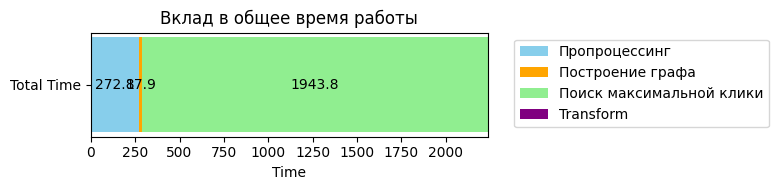

In [30]:
mean_times = [np.mean(preprocess_time) * 1000, np.mean(graph_construction_time) * 1000, np.mean(max_clique_time) * 1000, np.mean(transform_time) * 1000]
labels = ['Пропроцессинг', 'Построение графа', 'Поиск максимальной клики', 'Transform']

total_time = sum(mean_times)

plt.figure(figsize=(8, 2))
bar_height = 0.8

plt.barh(['Total Time'], [mean_times[0]], height=bar_height, label=labels[0], color='skyblue')
plt.barh(['Total Time'], [mean_times[1]], height=bar_height, left=[mean_times[0]], label=labels[1], color='orange')
plt.barh(['Total Time'], [mean_times[2]], height=bar_height, left=[mean_times[0] + mean_times[1]], label=labels[2], color='lightgreen')
plt.barh(['Total Time'], [mean_times[3]], height=bar_height, left=[mean_times[0] + mean_times[1] + mean_times[2]], label=labels[3], color='purple')

for i, time in enumerate(mean_times):
    x_position = sum(mean_times[:i]) + time / 2
    plt.text(x_position, 0, f'{time:.1f}', ha='center', va='center', color='black', fontsize=10)

plt.xlabel('Time')
plt.title('Вклад в общее время работы')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [48]:
threshold = 0.7
print('Precision:', np.sum([(fitness > threshold) * (max(error) < 0.5) \
                                              for fitness, error in icp_results]) / \
                    np.sum([(fitness > threshold) for fitness, error in icp_results]))
print('Recall with IoU > 0.5:', np.sum([(icp_results[i][0] > threshold) * (max(icp_results[i][1]) < 0.5) \
                                              for i in range(155) if ious[i] > 0.5]) / \
                                sum([i > 0.5 for i in ious]))
print('Recall with IoU > 0.25:', np.sum([(icp_results[i][0] > threshold) * (max(icp_results[i][1]) < 0.5) \
                                              for i in range(155) if ious[i] > 0.25]) / \
                                sum([i > 0.25 for i in ious]))

Precision: 0.1875
Recall with IoU > 0.5: 0.0037174721189591076
Recall with IoU > 0.25: 0.0006685981724983285


In [42]:
pos = 0
errors = []
transforms = []

for root, dirs, files in os.walk(data_dir):
    if 'trans.txt' in files:
        trans_file_path = os.path.join(root, 'trans.txt')
        transforms.append(
            np.loadtxt(trans_file_path)
        )

In [55]:
for ii, test_name in tqdm(list(enumerate(os.listdir(pr_data_dir)))):
    test_dir = os.path.join(pr_data_dir, test_name)
    try:
        transforms_ = np.loadtxt(os.path.join(test_dir, 'transforms.txt'))
    except FileNotFoundError:
        continue

    if transforms_.size == 0:
        continue
    if transforms_.ndim == 1:
        transforms_ = transforms_[np.newaxis, :]

    cand_clouds = {}
    cand_poses = {}

    # Reference cloud (from robot)
    with np.load(os.path.join(test_dir, 'cloud.npz')) as CloudFile:
        ref_cloud = CloudFile['arr_0']

    ref_cloud = ref_cloud[:, :3]
    ref_cloud = ref_cloud[ref_cloud == ref_cloud].reshape((-1, 3))

    if transforms_.size == 0:
        pass

    for idx in transforms_[:, 0]:
        cloud = np.load(os.path.join(graph_data_dir, str(int(idx)), 'cloud.npz'))['arr_0']
        pose_stamped = np.loadtxt(os.path.join(graph_data_dir, str(int(idx)), 'pose_stamped.txt'))
        cand_clouds[int(idx)] = cloud
        cand_poses[int(idx)] = pose_stamped[1:]

    gt_poses = np.loadtxt(os.path.join(test_dir, 'gt_poses.txt'))

    for i in range(transforms_.size // 7):
        if pos >= len(transforms):
            break

        if np.linalg.det(transforms[pos]) == 0:
            pos += 1
            continue

        idx = transforms_[i, 0]
        gt_pose = cand_poses[int(idx)]
        pose_shift = get_rel_pose(*gt_poses[0], *gt_pose)
        iou = get_iou(*pose_shift, ref_cloud, cloud, visualize=False)

        er = transformation_error(pose_shift, np.linalg.inv(transforms[pos]))
        errors.append([iou, er])
        pos += 1

  0%|          | 0/1648 [00:00<?, ?it/s]

/tmp/ipykernel_39733/1622821447.py:4: UserWarning: loadtxt: input contained no data: "../data/place_recognition_data/1710495413820100000/transforms.txt"
  transforms_ = np.loadtxt(os.path.join(test_dir, 'transforms.txt'))
/tmp/ipykernel_39733/1622821447.py:4: UserWarning: loadtxt: input contained no data: "../data/place_recognition_data/1710506453259492000/transforms.txt"
  transforms_ = np.loadtxt(os.path.join(test_dir, 'transforms.txt'))
/tmp/ipykernel_39733/1622821447.py:4: UserWarning: loadtxt: input contained no data: "../data/place_recognition_data/1710504397952582000/transforms.txt"
  transforms_ = np.loadtxt(os.path.join(test_dir, 'transforms.txt'))
/tmp/ipykernel_39733/1622821447.py:4: UserWarning: loadtxt: input contained no data: "../data/place_recognition_data/1710505116224765000/transforms.txt"
  transforms_ = np.loadtxt(os.path.join(test_dir, 'transforms.txt'))
/tmp/ipykernel_39733/1622821447.py:4: UserWarning: loadtxt: input contained no data: "../data/place_recognition_

In [56]:
sum([(max(el[1]) < 0.5) for el in errors])

0

In [ ]:
threshold = 0.7
# print('Precision:', np.sum([(fitness > threshold) * (max(error) < 0.5) \
#                                               for fitness, error in icp_results]) / \
#                     np.sum([(fitness > threshold) for fitness, error in icp_results]))
print('Recall with IoU > 0.5:', np.sum([(icp_results[i][0] > threshold) * (max(icp_results[i][1]) < 0.5) \
                                              for i in range(155) if ious[i] > 0.5]) / \
                                sum([i > 0.5 for i in ious]))
print('Recall with IoU > 0.25:', np.sum([(icp_results[i][0] > threshold) * (max(icp_results[i][1]) < 0.5) \
                                              for i in range(155) if ious[i] > 0.25]) / \
                                sum([i > 0.25 for i in ious]))

In [ ]:
# def calculate_fitness(src, tgt, transformation):
#     fitness_score = 0.0

#     src.transform(transformation)

#     # std::vector<int> nn_indices (1);
#     # std::vector<float> nn_dists (1);
#     pcd_tree = o3d.geometry.KDTreeFlann(src)

#     nr = 0
#     for i in range(len(src)):
#         [k, idx, _] = pcd_tree.search_knn_vector_3d(src.points[i], 1)

#         dist

#     # for (size_t i = 0; i < input_transformed.points.size (); ++i)
#     # {
#     #     // Find its nearest neighbor in the target
#     #     tree_->nearestKSearch (src.points[i], 1, nn_indices, nn_dists);

#     #     // Deal with occlusions (incomplete targets)
#     #     if (nn_dists[0] <= max_range)
#     #     {
#     #     // Add to the fitness score
#     #     fitness_score += nn_dists[0];
#     #     nr++;
#     #     } 
#     # } 

#     if nr > 0:
#         return fitness_score / nr
#     else:
#         return float('inf')